## Introduction
This code is part of a broader research project on surrogate modeling for multi-objective variability estimation.
It implements a pipeline to train and iteratively refine a surrogate model—specifically, a Gaussian Process (GP) capable of predicting the Frobenius norm ∥C(λ)∥ of the local covariance matrix of Pareto-optimal solutions obtained via scalarized optimization.
The surrogate model supports active learning through Expected Improvement (EI), aligning with the scalable, problem-aware methodology described by [1] and related frameworks.


References:
[1] Xiaoran Ruan, Ke Li, Bilel Derbel, and Arnaud Liefooghe. 2020. Surrogate assisted evolutionary algorithm for medium scale multi-objective optimisation problems. In Proceedings of the 2020 Genetic and Evolutionary Computation Conference (GECCO '20). Association for Computing Machinery, New York, NY, USA, 560–568. https://doi.org/10.1145/3377930.3390191

In [ ]:
%pip install pandas numpy matplotlib scikit-learn scipy pymoo seaborn forestci 

In [9]:
from pymoo.problems.many import DTLZ2
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import norm
from itertools import product
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, RBF, DotProduct, WhiteKernel, RationalQuadratic
import matplotlib.pyplot as plt


# Define the multi-objective benchmark problem DTLZ2.
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)


def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)



def stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    stratify_labels = discretizer.fit_transform(X[:, 0].reshape(-1, 1)).ravel()  
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_labels
    )
    return X_train, X_test, y_train, y_test


def train_gp(X, y, best_kernel, verbose=True):
    if verbose:
        print("GP Started Training ")
        print(f"Kernel used: {best_kernel}")
  
    model = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=20, alpha=1e-3, normalize_y=True, random_state=42)
    model.fit(X, y)
    if verbose:
        print("GP Training Ended")
        print(f"Log-Marginal-Likelihood : {model.log_marginal_likelihood_value_:.4f}")
    
    return model

def select_best_kernel(X_train, y_train, verbose=True):
    kernels = [
    
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * DotProduct() + WhiteKernel(),
    ConstantKernel(1.0) * (RBF(length_scale=1.0) + WhiteKernel()),
    ConstantKernel(1.0) * RBF(length_scale=1.0) + Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * (RationalQuadratic() + Matern(nu=1.5)) + WhiteKernel()
]
    
    best_score = -np.inf
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    if verbose:
        print("Kernel Selection")

    for kernel_idx, kernel in enumerate(kernels):
        scores = []
        mae_scores = []  # Per memorizzare il MAE sui dati di validazione
        if verbose:
            print(f"\n[Kernel {kernel_idx + 1}/{len(kernels)}] Testing kernel: {kernel}")

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            # Addestramento del modello
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)
            model.fit(X_tr, y_tr)

            # Calcolo del log-marginal-likelihood
            log_likelihood = model.log_marginal_likelihood_value_
            scores.append(log_likelihood)

            # Predizione sui dati di validazione
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            mae_scores.append(mae)

            if verbose:
                print(f"  [Fold {fold_idx + 1}] Log-Likelihood: {log_likelihood:.4f}, MAE: {mae:.4f}")

        avg_score = np.mean(scores)
        avg_mae = np.mean(mae_scores)  # Media del MAE

        if verbose:
            print(f"[Kernel {kernel_idx + 1}] Log-Likelihood avarage: {avg_score:.4f}, MAE avarage: {avg_mae:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_kernel = kernel
            if verbose:
                print(f"  Best Kernel {kernel_idx + 1}!")

    if verbose:
        print(f"\n[Kernel Selection]  Best Kernel : {best_kernel} with Log-Likelihood : {best_score:.4f}")

    return best_kernel


In [2]:
def generate_lambda_simplex_extremes(n_samples=3000):
    base = np.identity(3)
    extra = np.random.dirichlet([0.2]*3, size=n_samples)
    return np.vstack((base, extra))

#lambda_grid = generate_lambda_simplex_extremes(3000)

In [3]:
# Step 4: Active sampling via Expected Improvement (EI)
# Implement active sampling strategy using the Expected Improvement acquisition function.

def diversity_enhanced_ei(lambda_candidates, model, X_scaler, y_best_scaled, top_k=100):
    X_cand_scaled = X_scaler.transform(lambda_candidates)
    mu, sigma = model.predict(X_cand_scaled, return_std=True)
    with np.errstate(divide='warn'):
        imp = mu.reshape(-1, 1) - y_best_scaled
        Z = imp / sigma.reshape(-1, 1)
        ei = imp * norm.cdf(Z) + sigma.reshape(-1, 1) * norm.pdf(Z)
        ei = ei.ravel()
    dist_matrix = cdist(lambda_candidates, lambda_candidates)
    diversity_score = dist_matrix.mean(axis=1)
    combined_score = ei + 0.1 * diversity_score + 0.5 * sigma
    top_idx = np.argsort(-combined_score)[:top_k]
    return lambda_candidates[top_idx]


def active_learning_with_ei(model, X_scaler, y_scaler, lambda_grid, dataset, top_k=10):
    y_best_scaled = np.min(dataset["frob_norm"].values)
    lambda_selected = diversity_enhanced_ei(
        lambda_candidates=lambda_grid,
        model=model,
        X_scaler=X_scaler,
        y_best_scaled=y_best_scaled,
        top_k=top_k,
        w_ei=1.0,
        w_div=0.1,
        w_sigma=0.5
    )
    updated_dataset = update_dataset_with_new_data(lambda_selected, dataset)
    return updated_dataset




In [4]:
# Step 5: Update Dataset with new data
# Implement an iterative update of the GP model with new candidate solutions selected via Expected Improvement, as proposed [1]. This iterative update helps maintain a robust model by incorporating newly evaluated points that improve the accuracy and coverage of the surrogate model.
def update_dataset_with_new_data(lambda_selected, dataset, base_filename="updated_dataset", window_size=10):
    n_vars = problem.n_var
    n_obj = problem.n_obj
    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)
        if len(new_x_star) >= 2 :
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
    updated_dataset = updated_dataset.dropna(subset=["frob_norm"])

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    new_filename = f"{base_filename}_{timestamp}.csv"
    updated_dataset.to_csv(new_filename, index=False)
    print(f"Dataset aggiornato salvato come: {new_filename}")

    return updated_dataset

In [5]:
def evaluate_on_test(gpr, X_test, y_test, y_scaler):
    y_pred, y_std = gpr.predict(X_test, return_std=True)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    scale = y_scaler.scale_[0] if y_scaler.scale_.shape else y_scaler.scale_

    print("[Test Evaluation]")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("R2:", r2_score(y_test_inv, y_pred_inv))
    print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))

    plt.figure(figsize=(7, 6))
    plt.errorbar(y_test_inv, y_pred_inv.ravel(), yerr=y_std * scale, fmt='o', alpha=0.6)
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
    plt.title("GP Prediction vs True ‖C(λ)‖_F")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[Initial GP Training]
GP Started Training 
Kernel used: 1**2 * RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)
GP Training Ended
Log-Marginal-Likelihood : -1134.7559
[Test Evaluation]
RMSE: 0.06340018663212814
R2: 0.004685206992093183
MAE: 0.049003773010256955


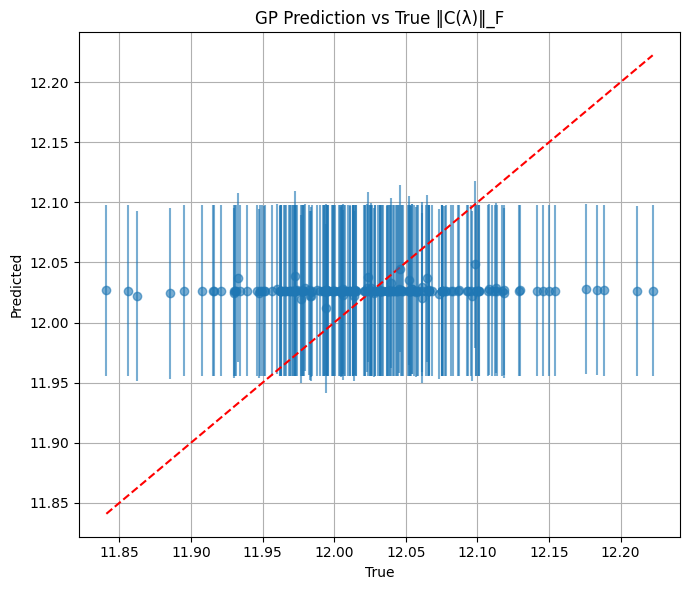


=== Iteration 1/3 ===
Dataset aggiornato salvato come: updated_dataset_20250511_164941.csv
Dimensioni dei dati di addestramento: (1099, 3), (1099,)
Kernel Selection

[Kernel 1/5] Testing kernel: 1**2 * Matern(length_scale=1, nu=1.5)
  [Fold 1] Log-Likelihood: -1124.2608, MAE: 0.4188
  [Fold 2] Log-Likelihood: -1218.8876, MAE: 0.4492
  [Fold 3] Log-Likelihood: -1141.9967, MAE: 0.3416
  [Fold 4] Log-Likelihood: -1247.2450, MAE: 0.5908
  [Fold 5] Log-Likelihood: -1235.1937, MAE: 0.4547
[Kernel 1] Log-Likelihood avarage: -1193.5168, MAE avarage: 0.4510
  Best Kernel 1!

[Kernel 2/5] Testing kernel: 1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1)


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 1] Log-Likelihood: -1247.1184, MAE: 0.5847


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 2] Log-Likelihood: -1247.2541, MAE: 0.5629


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 3] Log-Likelihood: -1247.2146, MAE: 0.5355


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 4] Log-Likelihood: -1247.2435, MAE: 0.5909


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 5] Log-Likelihood: -1248.6789, MAE: 0.5739
[Kernel 2] Log-Likelihood avarage: -1247.5019, MAE avarage: 0.5696

[Kernel 3/5] Testing kernel: 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
  [Fold 1] Log-Likelihood: -681.7234, MAE: 0.2748
  [Fold 2] Log-Likelihood: -651.8120, MAE: 0.2416
  [Fold 3] Log-Likelihood: -681.4023, MAE: 0.2213
  [Fold 4] Log-Likelihood: -732.9451, MAE: 0.2139
  [Fold 5] Log-Likelihood: -732.0133, MAE: 0.2093
[Kernel 3] Log-Likelihood avarage: -695.9792, MAE avarage: 0.2322
  Best Kernel 3!

[Kernel 4/5] Testing kernel: 1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5)
  [Fold 1] Log-Likelihood: -680.0167, MAE: 0.2690


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 2] Log-Likelihood: -649.7738, MAE: 0.2336
  [Fold 3] Log-Likelihood: -679.2007, MAE: 0.2112
  [Fold 4] Log-Likelihood: -734.1102, MAE: 0.2039
  [Fold 5] Log-Likelihood: -735.4177, MAE: 0.1964
[Kernel 4] Log-Likelihood avarage: -695.7038, MAE avarage: 0.2228
  Best Kernel 4!

[Kernel 5/5] Testing kernel: 1**2 * RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)


c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\aless\Desktop\Tesi\Articolo\.venv\lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


  [Fold 1] Log-Likelihood: -677.4974, MAE: 0.2673
  [Fold 2] Log-Likelihood: -645.5204, MAE: 0.2386
  [Fold 3] Log-Likelihood: -675.7395, MAE: 0.2091
  [Fold 4] Log-Likelihood: -726.5616, MAE: 0.2116
  [Fold 5] Log-Likelihood: -726.6898, MAE: 0.2059
[Kernel 5] Log-Likelihood avarage: -690.4017, MAE avarage: 0.2265
  Best Kernel 5!

[Kernel Selection]  Best Kernel : 1**2 * RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1) with Log-Likelihood : -690.4017
GP Started Training 
Kernel used: 1**2 * RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)
GP Training Ended
Log-Marginal-Likelihood : -846.8524
Log-Likelihood durante l'addestramento finale: -846.8523669865905
[Test Evaluation]
RMSE: 21.11052554861303
R2: -1483.58631236345
MAE: 21.103378374381226


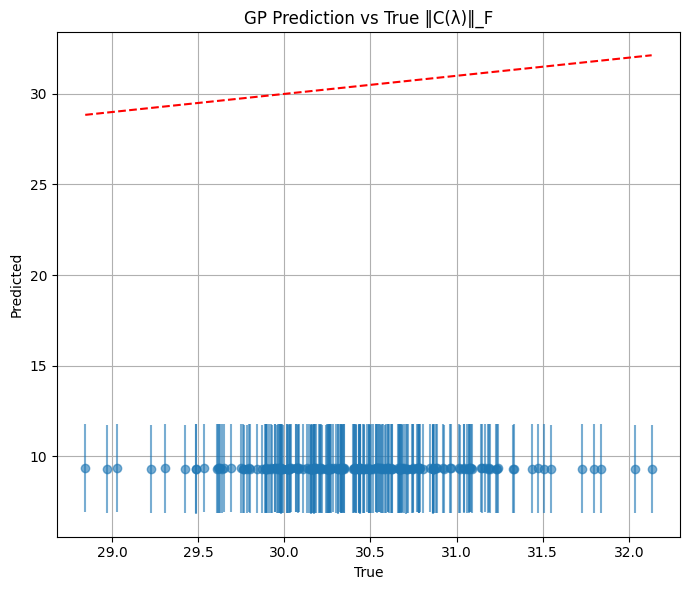


=== Iteration 2/3 ===
Dataset aggiornato salvato come: updated_dataset_20250511_172408.csv
Dimensioni dei dati di addestramento: (1198, 3), (1198,)
Kernel Selection

[Kernel 1/5] Testing kernel: 1**2 * Matern(length_scale=1, nu=1.5)


KeyboardInterrupt: 

In [12]:
df = pd.read_csv("dtlz2_dataset1.csv").dropna(subset=["frob_norm"])
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)
X = df[["lambda_1", "lambda_2", "lambda_3"]].values
y = df["frob_norm"].values.reshape(-1, 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42)

X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y).ravel()

# Initial model
print("[Initial GP Training]")
default_kernel = ConstantKernel(1.0) * (RationalQuadratic() + Matern(nu=1.5)) + WhiteKernel()
gpr = train_gp(X_train, y_train, best_kernel=default_kernel, verbose=True)
evaluate_on_test(gpr, X_test, y_test, y_scaler)

step = 0.01  
grid = np.arange(0, 1 + step, step)  
lambda_grid = np.array([lam for lam in product(grid, repeat=3) if np.isclose(sum(lam), 1)])  

dataset_memory = df.copy()

for iteration in range(5):
    print(f"\n=== Iteration {iteration+1}/3 ===")
    #lambda_grid = generate_lambda_simplex_extremes(3000)
    y_best_scaled = np.min(y_train)
    
    lambda_selected = diversity_enhanced_ei(lambda_candidates=lambda_grid,model=gpr,X_scaler=X_scaler,y_best_scaled=np.min(y_train),top_k=100)
    
    dataset_memory = update_dataset_with_new_data(lambda_selected, dataset_memory)
    X = dataset_memory[["lambda_1", "lambda_2", "lambda_3"]].values
    y = dataset_memory[["frob_norm"]].values

    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)

    X_train = X_scaler.transform(X)
    y_train = y_scaler.transform(y).ravel()
    print(f"Dimensioni dei dati di addestramento: {X_train.shape}, {y_train.shape}")
    best_kernel = select_best_kernel(X_train, y_train, verbose=True)
    gpr = train_gp(X_train, y_train, best_kernel=best_kernel, verbose=True)
    print(f"Log-Likelihood durante l'addestramento finale: {gpr.log_marginal_likelihood_value_}")
    evaluate_on_test(gpr,X_test, y_test, y_scaler)
